# Library

In [1]:
import os
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
from functools import partial

import numpy as np
import pandas as pd
import random
import math

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.metrics import mean_squared_error
import category_encoders as ce

from PIL import Image
import cv2
import pydicom

import torch

import lightgbm as lgb
from sklearn.linear_model import Ridge

import warnings
warnings.filterwarnings("ignore")

# Utils

In [2]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [3]:
OUTPUT_DICT = './'

ID = 'Patient_Week'
TARGET = 'FVC'
SEED = 42
seed_everything(seed=SEED)

N_FOLD = 4

# Data Loading

In [4]:
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
train[ID] = train['Patient'].astype(str) + '_' + train['Weeks'].astype(str)
print(train.shape)
train.head()

(1549, 8)


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Patient_Week
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,ID00007637202177411956430_-4
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,ID00007637202177411956430_5
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,ID00007637202177411956430_7
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,ID00007637202177411956430_9
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,ID00007637202177411956430_11


In [5]:
# construct train input

output = pd.DataFrame()
gb = train.groupby('Patient')
tk0 = tqdm(gb, total=len(gb))
for _, usr_df in tk0:
    usr_output = pd.DataFrame()
    for week, tmp in usr_df.groupby('Weeks'):
        rename_cols = {'Weeks': 'base_Week', 'FVC': 'base_FVC', 'Percent': 'base_Percent', 'Age': 'base_Age'}
        tmp = tmp.drop(columns='Patient_Week').rename(columns=rename_cols)
        drop_cols = ['Age', 'Sex', 'SmokingStatus', 'Percent']
        _usr_output = usr_df.drop(columns=drop_cols).rename(columns={'Weeks': 'predict_Week'}).merge(tmp, on='Patient')
        _usr_output['Week_passed'] = _usr_output['predict_Week'] - _usr_output['base_Week']
        usr_output = pd.concat([usr_output, _usr_output])
    output = pd.concat([output, usr_output])
    
train = output[output['Week_passed']!=0].reset_index(drop=True)
print(train.shape)
train.head()


(12144, 11)


,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed
0,ID00007637202177411956430,5,2214,ID00007637202177411956430_5,-4,2315,58.253649,79,Male,Ex-smoker,9
1,ID00007637202177411956430,7,2061,ID00007637202177411956430_7,-4,2315,58.253649,79,Male,Ex-smoker,11
2,ID00007637202177411956430,9,2144,ID00007637202177411956430_9,-4,2315,58.253649,79,Male,Ex-smoker,13
3,ID00007637202177411956430,11,2069,ID00007637202177411956430_11,-4,2315,58.253649,79,Male,Ex-smoker,15
4,ID00007637202177411956430,17,2101,ID00007637202177411956430_17,-4,2315,58.253649,79,Male,Ex-smoker,21


In [6]:
# construct test input

test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')\
        .rename(columns={'Weeks': 'base_Week', 'FVC': 'base_FVC', 'Percent': 'base_Percent', 'Age': 'base_Age'})
submission = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv')
submission['Patient'] = submission['Patient_Week'].apply(lambda x: x.split('_')[0])
submission['predict_Week'] = submission['Patient_Week'].apply(lambda x: x.split('_')[1]).astype(int)
test = submission.drop(columns=['FVC', 'Confidence']).merge(test, on='Patient')
test['Week_passed'] = test['predict_Week'] - test['base_Week']
print(test.shape)
test.head()

(730, 10)


,Patient_Week,Patient,predict_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed
0,ID00419637202311204720264_-12,ID00419637202311204720264,-12,6,3020,70.186855,73,Male,Ex-smoker,-18
1,ID00419637202311204720264_-11,ID00419637202311204720264,-11,6,3020,70.186855,73,Male,Ex-smoker,-17
2,ID00419637202311204720264_-10,ID00419637202311204720264,-10,6,3020,70.186855,73,Male,Ex-smoker,-16
3,ID00419637202311204720264_-9,ID00419637202311204720264,-9,6,3020,70.186855,73,Male,Ex-smoker,-15
4,ID00419637202311204720264_-8,ID00419637202311204720264,-8,6,3020,70.186855,73,Male,Ex-smoker,-14


In [7]:
submission = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv')
print(submission.shape)
submission.head()

(730, 3)


,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2000,100
1,ID00421637202311550012437_-12,2000,100
2,ID00422637202311677017371_-12,2000,100
3,ID00423637202312137826377_-12,2000,100
4,ID00426637202313170790466_-12,2000,100


# Prepare folds

In [8]:
folds = train[[ID, 'Patient', TARGET]].copy()
#Fold = KFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)
Fold = GroupKFold(n_splits=N_FOLD)
groups = folds['Patient'].values
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[TARGET], groups)):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
folds.head()

,Patient_Week,Patient,FVC,fold
0,ID00007637202177411956430_5,ID00007637202177411956430,2214,2
1,ID00007637202177411956430_7,ID00007637202177411956430,2061,2
2,ID00007637202177411956430_9,ID00007637202177411956430,2144,2
3,ID00007637202177411956430_11,ID00007637202177411956430,2069,2
4,ID00007637202177411956430_17,ID00007637202177411956430,2101,2


# MODEL

In [9]:
#===========================================================
# model
#===========================================================
def run_single_lightgbm(param, train_df, test_df, folds, features, target, fold_num=0, categorical=[]):
    
    trn_idx = folds[folds.fold != fold_num].index
    val_idx = folds[folds.fold == fold_num].index
    logger.info(f'len(trn_idx) : {len(trn_idx)}')
    logger.info(f'len(val_idx) : {len(val_idx)}')
    
    if categorical == []:
        trn_data = lgb.Dataset(train_df.iloc[trn_idx][features],
                               label=target.iloc[trn_idx])
        val_data = lgb.Dataset(train_df.iloc[val_idx][features],
                               label=target.iloc[val_idx])
    else:
        trn_data = lgb.Dataset(train_df.iloc[trn_idx][features],
                               label=target.iloc[trn_idx],
                               categorical_feature=categorical)
        val_data = lgb.Dataset(train_df.iloc[val_idx][features],
                               label=target.iloc[val_idx],
                               categorical_feature=categorical)

    oof = np.zeros(len(train_df))
    predictions = np.zeros(len(test_df))

    num_round = 10000

    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets=[trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds=100)

    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = fold_num

    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration)
    
    # RMSE
    logger.info("fold{} RMSE score: {:<8.5f}".format(fold_num, np.sqrt(mean_squared_error(target[val_idx], oof[val_idx]))))
    
    return oof, predictions, fold_importance_df


def run_kfold_lightgbm(param, train, test, folds, features, target, n_fold=5, categorical=[]):
    
    logger.info(f"================================= {n_fold}fold lightgbm =================================")
    
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    feature_importance_df = pd.DataFrame()

    for fold_ in range(n_fold):
        print("Fold {}".format(fold_))
        _oof, _predictions, fold_importance_df = run_single_lightgbm(param,
                                                                     train,
                                                                     test,
                                                                     folds,
                                                                     features,
                                                                     target,
                                                                     fold_num=fold_,
                                                                     categorical=categorical)
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        oof += _oof
        predictions += _predictions / n_fold

    # RMSE
    logger.info("CV RMSE score: {:<8.5f}".format(np.sqrt(mean_squared_error(target, oof))))

    logger.info(f"=========================================================================================")
    
    return feature_importance_df, predictions, oof

    
def show_feature_importance(feature_importance_df, name):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:50].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    #plt.figure(figsize=(8, 16))
    plt.figure(figsize=(6, 4))
    sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged/folds)')
    plt.tight_layout()
    plt.savefig(OUTPUT_DICT+f'feature_importance_{name}.png')

## predict FVC

================================= 4fold lightgbm =================================
len(trn_idx) : 9110
len(val_idx) : 3034


Fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 368.79	valid_1's rmse: 377.079
[200]	training's rmse: 236.503	valid_1's rmse: 233.713
[300]	training's rmse: 201.557	valid_1's rmse: 201.141
[400]	training's rmse: 188.765	valid_1's rmse: 196.958
[500]	training's rmse: 181.299	valid_1's rmse: 197.479
Early stopping, best iteration is:
[412]	training's rmse: 187.619	valid_1's rmse: 196.853


fold0 RMSE score: 196.85263
len(trn_idx) : 9110
len(val_idx) : 3034


Fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 352.172	valid_1's rmse: 486.568
[200]	training's rmse: 218.824	valid_1's rmse: 369.573
[300]	training's rmse: 184.234	valid_1's rmse: 344.655
[400]	training's rmse: 171.032	valid_1's rmse: 341.882
[500]	training's rmse: 163.658	valid_1's rmse: 340.728
[600]	training's rmse: 157.318	valid_1's rmse: 342.222
Early stopping, best iteration is:
[504]	training's rmse: 163.357	valid_1's rmse: 340.529


fold1 RMSE score: 340.52883
len(trn_idx) : 9100
len(val_idx) : 3044


Fold 2
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 376.869	valid_1's rmse: 326.055
[200]	training's rmse: 222.394	valid_1's rmse: 269.459
[300]	training's rmse: 182.202	valid_1's rmse: 267.702
Early stopping, best iteration is:
[257]	training's rmse: 193.451	valid_1's rmse: 267.237


fold2 RMSE score: 267.23726
len(trn_idx) : 9112
len(val_idx) : 3032


Fold 3
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 359.016	valid_1's rmse: 395.934
[200]	training's rmse: 223.736	valid_1's rmse: 293.691
[300]	training's rmse: 189.344	valid_1's rmse: 286.105
Early stopping, best iteration is:
[285]	training's rmse: 192.202	valid_1's rmse: 285.905


fold3 RMSE score: 285.90497
CV RMSE score: 277.41973


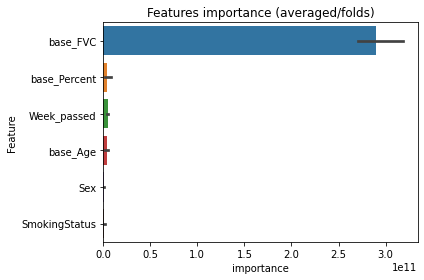

In [10]:
target = train[TARGET]
test[TARGET] = np.nan

# features
cat_features = ['Sex', 'SmokingStatus']
num_features = [c for c in test.columns if (test.dtypes[c] != 'object') & (c not in cat_features)]
features = num_features + cat_features
drop_features = [ID, TARGET, 'predict_Week', 'base_Week']
features = [c for c in features if c not in drop_features]

if cat_features:
    ce_oe = ce.OrdinalEncoder(cols=cat_features, handle_unknown='impute')
    ce_oe.fit(train)
    train = ce_oe.transform(train)
    test = ce_oe.transform(test)
        
lgb_param = {'objective': 'regression',
             'metric': 'rmse',
             'boosting_type': 'gbdt',
             'learning_rate': 0.01,
             'seed': SEED,
             'max_depth': -1,
             'verbosity': -1,
            }

feature_importance_df, predictions, oof = run_kfold_lightgbm(lgb_param, train, test, folds, features, target, 
                                                             n_fold=N_FOLD, categorical=cat_features)
    
show_feature_importance(feature_importance_df, TARGET)

In [11]:
train['FVC_pred'] = oof
test['FVC_pred'] = predictions

## make Confidence labels

In [12]:
# baseline score
train['Confidence'] = 100
train['sigma_clipped'] = train['Confidence'].apply(lambda x: max(x, 70))
train['diff'] = abs(train['FVC'] - train['FVC_pred'])
train['delta'] = train['diff'].apply(lambda x: min(x, 1000))
train['score'] = -math.sqrt(2)*train['delta']/train['sigma_clipped'] - np.log(math.sqrt(2)*train['sigma_clipped'])
score = train['score'].mean()
print(score)

-7.458754308882443


In [13]:
train.head(10)

,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed,FVC_pred,Confidence,sigma_clipped,diff,delta,score
0,ID00007637202177411956430,5,2214,ID00007637202177411956430_5,-4,2315,58.253649,79,1,1,9,2235.482874,100,100,21.482874,21.482874,-5.255557
1,ID00007637202177411956430,7,2061,ID00007637202177411956430_7,-4,2315,58.253649,79,1,1,11,2235.482874,100,100,174.482874,174.482874,-7.419304
2,ID00007637202177411956430,9,2144,ID00007637202177411956430_9,-4,2315,58.253649,79,1,1,13,2244.978289,100,100,100.978289,100.978289,-6.379792
3,ID00007637202177411956430,11,2069,ID00007637202177411956430_11,-4,2315,58.253649,79,1,1,15,2244.978289,100,100,175.978289,175.978289,-7.440453
4,ID00007637202177411956430,17,2101,ID00007637202177411956430_17,-4,2315,58.253649,79,1,1,21,2244.978289,100,100,143.978289,143.978289,-6.987904
5,ID00007637202177411956430,29,2000,ID00007637202177411956430_29,-4,2315,58.253649,79,1,1,33,2246.049507,100,100,246.049507,246.049507,-8.431409
6,ID00007637202177411956430,41,2064,ID00007637202177411956430_41,-4,2315,58.253649,79,1,1,45,2246.049507,100,100,182.049507,182.049507,-7.526313
7,ID00007637202177411956430,57,2057,ID00007637202177411956430_57,-4,2315,58.253649,79,1,1,61,2246.049507,100,100,189.049507,189.049507,-7.625308
8,ID00007637202177411956430,-4,2315,ID00007637202177411956430_-4,5,2214,55.712129,79,1,1,-9,2306.659647,100,100,8.340353,8.340353,-5.069694
9,ID00007637202177411956430,7,2061,ID00007637202177411956430_7,5,2214,55.712129,79,1,1,2,2253.537017,100,100,192.537017,192.537017,-7.674628


In [14]:
import scipy as sp

def loss_func(weight, row):
    confidence = weight
    sigma_clipped = max(confidence, 70)
    diff = abs(row['FVC'] - row['FVC_pred'])
    delta = min(diff, 1000)
    score = -math.sqrt(2)*delta/sigma_clipped - np.log(math.sqrt(2)*sigma_clipped)
    return -score

results = []
tk0 = tqdm(train.iterrows(), total=len(train))
for _, row in tk0:
    loss_partial = partial(loss_func, row=row)
    weight = [100]
    #bounds = [(70, 100)]
    #result = sp.optimize.minimize(loss_partial, weight, method='SLSQP', bounds=bounds)
    result = sp.optimize.minimize(loss_partial, weight, method='SLSQP')
    x = result['x']
    results.append(x[0])

In [15]:
# optimized score
train['Confidence'] = results
train['sigma_clipped'] = train['Confidence'].apply(lambda x: max(x, 70))
train['diff'] = abs(train['FVC'] - train['FVC_pred'])
train['delta'] = train['diff'].apply(lambda x: min(x, 1000))
train['score'] = -math.sqrt(2)*train['delta']/train['sigma_clipped'] - np.log(math.sqrt(2)*train['sigma_clipped'])
score = train['score'].mean()
print(score)

-6.448063956816574


In [16]:
train.head(10)

,Patient,predict_Week,FVC,Patient_Week,base_Week,base_FVC,base_Percent,base_Age,Sex,SmokingStatus,Week_passed,FVC_pred,Confidence,sigma_clipped,diff,delta,score
0,ID00007637202177411956430,5,2214,ID00007637202177411956430_5,-4,2315,58.253649,79,1,1,9,2235.482874,54.486858,70.000000,21.482874,21.482874,-5.029088
1,ID00007637202177411956430,7,2061,ID00007637202177411956430_7,-4,2315,58.253649,79,1,1,11,2235.482874,246.688087,246.688087,174.482874,174.482874,-6.854974
2,ID00007637202177411956430,9,2144,ID00007637202177411956430_9,-4,2315,58.253649,79,1,1,13,2244.978289,142.763325,142.763325,100.978289,100.978289,-6.308053
3,ID00007637202177411956430,11,2069,ID00007637202177411956430_11,-4,2315,58.253649,79,1,1,15,2244.978289,248.792767,248.792767,175.978289,175.978289,-6.863508
4,ID00007637202177411956430,17,2101,ID00007637202177411956430_17,-4,2315,58.253649,79,1,1,21,2244.978289,203.417732,203.417732,143.978289,143.978289,-6.662810
5,ID00007637202177411956430,29,2000,ID00007637202177411956430_29,-4,2315,58.253649,79,1,1,33,2246.049507,347.737897,347.737897,246.049507,246.049507,-7.198680
6,ID00007637202177411956430,41,2064,ID00007637202177411956430_41,-4,2315,58.253649,79,1,1,45,2246.049507,257.332167,257.332167,182.049507,182.049507,-6.897426
7,ID00007637202177411956430,57,2057,ID00007637202177411956430_57,-4,2315,58.253649,79,1,1,61,2246.049507,267.151193,267.151193,189.049507,189.049507,-6.935156
8,ID00007637202177411956430,-4,2315,ID00007637202177411956430_-4,5,2214,55.712129,79,1,1,-9,2306.659647,63.712848,70.000000,8.340353,8.340353,-4.763569
9,ID00007637202177411956430,7,2061,ID00007637202177411956430_7,5,2214,55.712129,79,1,1,2,2253.537017,272.027665,272.027665,192.537017,192.537017,-6.953436


## predict Confidence

================================= 4fold lightgbm =================================
len(trn_idx) : 9110
len(val_idx) : 3034


Fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 222.095	valid_1's rmse: 188.356


fold0 RMSE score: 184.17913
len(trn_idx) : 9110
len(val_idx) : 3034


Early stopping, best iteration is:
[16]	training's rmse: 262.255	valid_1's rmse: 184.179
Fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 201.146	valid_1's rmse: 291.42


fold1 RMSE score: 290.02523
len(trn_idx) : 9100
len(val_idx) : 3044


[200]	training's rmse: 184.787	valid_1's rmse: 291.061
Early stopping, best iteration is:
[157]	training's rmse: 190.417	valid_1's rmse: 290.025
Fold 2
Training until validation scores don't improve for 100 rounds


fold2 RMSE score: 252.27916
len(trn_idx) : 9112
len(val_idx) : 3032


[100]	training's rmse: 200.306	valid_1's rmse: 259.183
Early stopping, best iteration is:
[11]	training's rmse: 245.959	valid_1's rmse: 252.279
Fold 3
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 204.14	valid_1's rmse: 266.5
[200]	training's rmse: 188.1	valid_1's rmse: 260.572
[300]	training's rmse: 178.802	valid_1's rmse: 257.388


fold3 RMSE score: 256.70580
CV RMSE score: 248.78824


[400]	training's rmse: 172.604	valid_1's rmse: 257.377
Early stopping, best iteration is:
[361]	training's rmse: 174.803	valid_1's rmse: 256.706


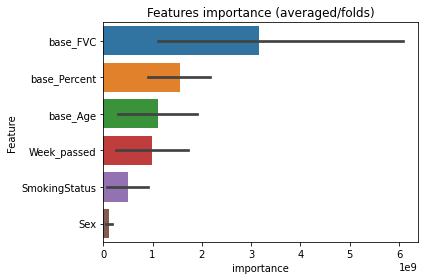

In [17]:
TARGET = 'Confidence'

target = train[TARGET]
test[TARGET] = np.nan

# features
cat_features = ['Sex', 'SmokingStatus']
num_features = [c for c in test.columns if (test.dtypes[c] != 'object') & (c not in cat_features)]
features = num_features + cat_features
drop_features = [ID, TARGET, 'predict_Week', 'base_Week', 'FVC', 'FVC_pred']
features = [c for c in features if c not in drop_features]

lgb_param = {'objective': 'regression',
             'metric': 'rmse',
             'boosting_type': 'gbdt',
             'learning_rate': 0.01,
             'seed': SEED,
             'max_depth': -1,
             'verbosity': -1,
            }

feature_importance_df, predictions, oof = run_kfold_lightgbm(lgb_param, train, test, folds, features, target, 
                                                             n_fold=N_FOLD, categorical=cat_features)
    
show_feature_importance(feature_importance_df, TARGET)

In [18]:
train['Confidence'] = oof
train['sigma_clipped'] = train['Confidence'].apply(lambda x: max(x, 70))
train['diff'] = abs(train['FVC'] - train['FVC_pred'])
train['delta'] = train['diff'].apply(lambda x: min(x, 1000))
train['score'] = -math.sqrt(2)*train['delta']/train['sigma_clipped'] - np.log(math.sqrt(2)*train['sigma_clipped'])
score = train['score'].mean()
print(score)

-6.850942590183579


In [19]:
def lb_metric(train):
    train['Confidence'] = oof
    train['sigma_clipped'] = train['Confidence'].apply(lambda x: max(x, 70))
    train['diff'] = abs(train['FVC'] - train['FVC_pred'])
    train['delta'] = train['diff'].apply(lambda x: min(x, 1000))
    train['score'] = -math.sqrt(2)*train['delta']/train['sigma_clipped'] - np.log(math.sqrt(2)*train['sigma_clipped'])
    score = train['score'].mean()
    return score

In [20]:
score = lb_metric(train)
logger.info(f'Local Score: {score}')

Local Score: -6.850942590183579


In [21]:
test['Confidence'] = predictions

# Submission

In [22]:
submission.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2000,100
1,ID00421637202311550012437_-12,2000,100
2,ID00422637202311677017371_-12,2000,100
3,ID00423637202312137826377_-12,2000,100
4,ID00426637202313170790466_-12,2000,100


In [23]:
sub = submission.drop(columns=['FVC', 'Confidence']).merge(test[['Patient_Week', 'FVC_pred', 'Confidence']], 
                                                           on='Patient_Week')
sub.columns = submission.columns
sub.to_csv('submission.csv', index=False)
sub.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2973.065286,241.444533
1,ID00421637202311550012437_-12,2849.757343,218.881313
2,ID00422637202311677017371_-12,1985.328903,217.622299
3,ID00423637202312137826377_-12,3369.942669,272.375029
4,ID00426637202313170790466_-12,2950.882768,226.946869
